In [82]:
import os
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
from tensorflow.keras.models import Model
import tensorflow as tf

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import librosa 
import matplotlib.pyplot as plt
import pandas as pd


from sklearn.metrics import confusion_matrix, classification_report

In [88]:
# Загружаем пути данных по меткам, наши аудиоданные имеют такую структуру
# в data/Full_bg_data/ лежат папки с аудиофайлами без кодового слова
#  d data/TalkFlow/ лежат папки с аудиофайлами с кодовым словом
# такая структура используется для возможности упорядочить аудиофайлы по тем кто их записывал


data_path_dict = {
    0: [os.path.join("data/Full_bg_data/", folder, file_name) 
        for folder in os.listdir("data/Full_bg_data/") 
        for file_name in os.listdir(os.path.join("data/Full_bg_data/", folder))],
    1: [os.path.join("data/TalkFlow/", folder, file_name)  
        for folder in os.listdir("data/TalkFlow/") 
        for file_name in os.listdir(os.path.join("data/TalkFlow/", folder))],
}




In [84]:
# загружаем аудиоданные и обрабатываем
# необычным моментов является то, что чем меньше n_mfcc тем выше точность,
# хотя этот параметр прямо проспорционален количеству информации

X = []
y = []

def preprocess_audio_data(audio_data):
    return np.array([librosa.feature.mfcc(y=y, sr=44100, n_mfcc=5) for y in audio_data])

def load_audio_data(file_paths):
    audio_data = []
    for file_path in file_paths:
        y, sr = librosa.load(file_path, sr=None)
        audio_data.append(y)
    return audio_data

for class_id, file_paths in data_path_dict.items():
    audio_data = load_audio_data(file_paths)
    preprocessed_data = preprocess_audio_data(audio_data)
    X.extend(preprocessed_data)
    y.extend([class_id] * len(preprocessed_data))

X = np.array(X)
y = np.array(y)

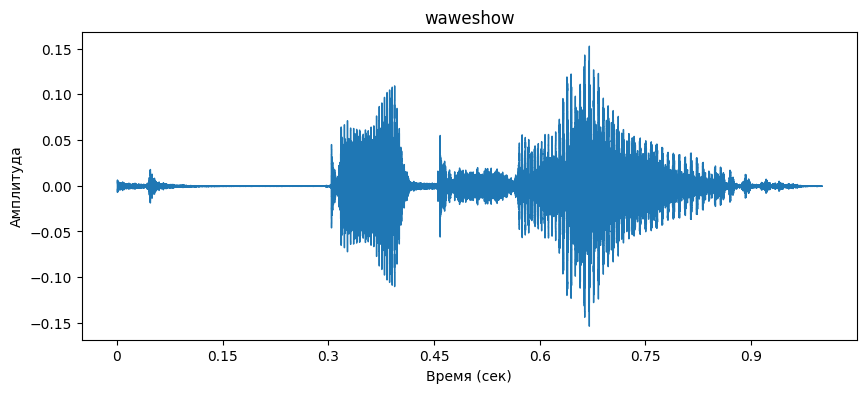

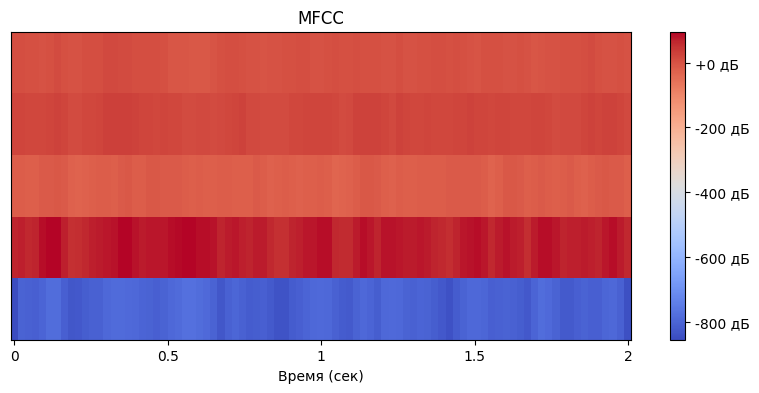

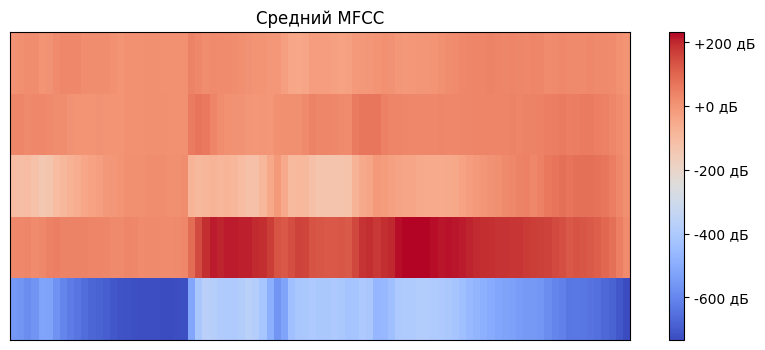

In [85]:
# визуализация
a_data = audio_data[0] 
plt.figure(figsize=(10, 4))
librosa.display.waveshow(a_data, sr=44100)
plt.title('waweshow')
plt.xlabel('Время (сек)')
plt.ylabel('Амплитуда')
plt.show()

#mfcc
plt.figure(figsize=(10, 4))
librosa.display.specshow(X[0], x_axis='time')
plt.colorbar(format='%+2.0f дБ')
plt.title('MFCC')
plt.xlabel('Время (сек)')
plt.show()

# средний MFCC для X[0]
plt.figure(figsize=(10, 4))
librosa.display.specshow( np.array(librosa.feature.mfcc(y=a_data, sr=44100, n_mfcc=5)))
plt.colorbar(format='%+2.0f дБ')
plt.title('Средний MFCC')
plt.show()




In [86]:
# Разбиваем данные 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

In [87]:
# дополнительное использование Полносвязного слоя не дало результата
# В будущем возможно будет эффективна замена метрики

input_layer = Input(shape=(X.shape[1:]))
print(X.shape[1:])

# RNN слой
rnn_layer = LSTM(256, activation='tanh', return_sequences=False)(input_layer)

# Полносвязный слой
#dense_layer = Dense(12, activation='relu')(rnn_layer)

# Выходной слой
output_layer = Dense(1, activation='sigmoid')(rnn_layer)

# Создаем модель
model = Model(inputs=input_layer, outputs=output_layer)
print(model.summary())
# Компилируем модель
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

(5, 87)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 87)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               352256    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 352513 (1.34 MB)
Trainable params: 352513 (1.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [43]:
print("Model Score: \n")
history = model.fit(X_train, y_train, epochs=100, batch_size=128, shuffle=True,
                    validation_data=(X_test, y_test))
model.save("WWD_v3.h5")
score = model.evaluate(X_test, y_test)
print(score)


Model Score: 

Epoch 1/100
9/9 [==============================] - 6s 184ms/step - loss: 0.5800 - accuracy: 0.7065 - val_loss: 0.4801 - val_accuracy: 0.8080
Epoch 2/100
9/9 [==============================] - 0s 41ms/step - loss: 0.4027 - accuracy: 0.8478 - val_loss: 0.4290 - val_accuracy: 0.8333
Epoch 3/100
9/9 [==============================] - 0s 42ms/step - loss: 0.3349 - accuracy: 0.8777 - val_loss: 0.3909 - val_accuracy: 0.8478
Epoch 4/100
9/9 [==============================] - 0s 44ms/step - loss: 0.2718 - accuracy: 0.9058 - val_loss: 0.3483 - val_accuracy: 0.8551
Epoch 5/100
9/9 [==============================] - 0s 45ms/step - loss: 0.2286 - accuracy: 0.9266 - val_loss: 0.3237 - val_accuracy: 0.8949
Epoch 6/100
9/9 [==============================] - 0s 46ms/step - loss: 0.1951 - accuracy: 0.9493 - val_loss: 0.2985 - val_accuracy: 0.8804
Epoch 7/100
9/9 [==============================] - 0s 43ms/step - loss: 0.1664 - accuracy: 0.9692 - val_loss: 0.2833 - val_accuracy: 0.8986
Epoc

C:\Users\egors\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 0s 10ms/step - loss: 0.1839 - accuracy: 0.9420
[0.18392959237098694, 0.9420289993286133]


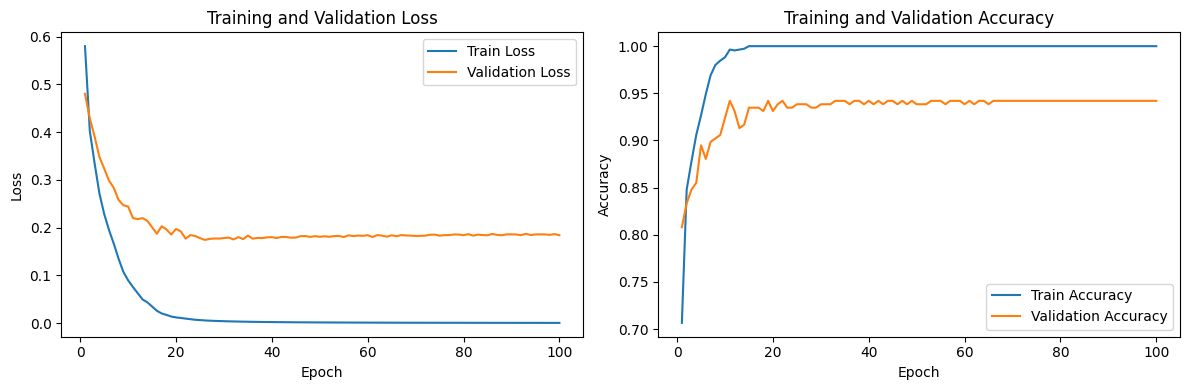

In [44]:
import matplotlib.pyplot as plt

# Получаем значения метрик обучения и валидации из объекта history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Создаем график
plt.figure(figsize=(12, 4))

# График функции потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()

# Отображаем график
plt.show()

In [54]:
# Проверим точность на данных с кодовым словом и без
file_path = 'data/TalkFlow/artem/oliver0.wav'

audio_data = load_audio_data([file_path])
processed_data = preprocess_audio_data(audio_data)
predictions2 = model.predict(processed_data)

file_path = 'data/Full_bg_data/artem_bg/Дубина0.wav'

audio_data = load_audio_data([file_path])
processed_data = preprocess_audio_data(audio_data)
predictions1 = model.predict(processed_data)

print('есть кодовое слово:',predictions2)
print('нет кодового слова:',predictions1)

1/1 [==============================] - 0s 40ms/step
есть кодовое слово: [[0.99964815]]
нет кодового слова: [[0.01963218]]


In [80]:
# тут мы проверим наши аудиоданные на возможные аномалии, так как проверить все записанные аудиоданнные сложно
# будет полезно с разными выборками проверить данные на возможные ошибки
# так мы минимизируем ошибки в обучении

#проверяем бэкграунд
print('looking for errors on Background')

X1 = []  # Здесь будут храниться аудиофайлы
y1 = []  # Здесь будут храниться пути к файлам

for classid, folder in enumerate(os.listdir("data/Full_bg_data/")):
    folder_path = os.path.join("data/Full_bg_data/", folder)
    file_paths = [os.path.join(folder_path, file_name) for file_name in os.listdir(folder_path)]
    
    for file_path in file_paths:
        audio_data = load_audio_data([file_path])
        preprocessed_data = preprocess_audio_data(audio_data)
        X1.append(preprocessed_data)
        y1.append(file_path)
        
for i, x in enumerate(X1):
    prediction = model.predict(x, verbose=0)
    if prediction[0] > 0.9:
        print( y1[i], ' with probability: ',  prediction[0])

#проверяем бэкграунд
print('looking for errors on WakeWord')

X1 = []  # Здесь будут храниться аудиофайлы
y1 = []  # Здесь будут храниться пути к файлам

for classid, folder in enumerate(os.listdir("data/TalkFlow/")):
    folder_path = os.path.join("data/TalkFlow/", folder)
    file_paths = [os.path.join(folder_path, file_name) for file_name in os.listdir(folder_path)]
    
    for file_path in file_paths:
        audio_data = load_audio_data([file_path])
        preprocessed_data = preprocess_audio_data(audio_data)
        X1.append(preprocessed_data)
        y1.append(file_path)
        
for i, x in enumerate(X1):
    prediction = model.predict(x, verbose=0)
    if prediction[0] < 0.9:
        print( y1[i], ' with probability: ',  prediction[0])

# пример моих аудиоданных без проверки


looking for errors on Background
data/Full_bg_data/dad\Dad140.wav  with probability:  [0.91261005]
data/Full_bg_data/dad\Dad158.wav  with probability:  [0.9864186]
looking for errors on WakeWord
data/TalkFlow/artem\oliver23.wav  with probability:  [0.7917243]
data/TalkFlow/artem\oliver25.wav  with probability:  [0.5670113]
data/TalkFlow/artem\oliver43.wav  with probability:  [0.6151519]
data/TalkFlow/artem\oliver49.wav  with probability:  [0.63066405]
data/TalkFlow/artem\oliver57.wav  with probability:  [0.896045]
data/TalkFlow/artem\oliver88.wav  with probability:  [0.83081645]
data/TalkFlow/baltoruss_goof\baltoruss14.wav  with probability:  [0.2025292]
data/TalkFlow/baltoruss_goof\baltoruss15.wav  with probability:  [0.35105145]
data/TalkFlow/baltoruss_goof\baltoruss33.wav  with probability:  [0.37935647]
data/TalkFlow/baltoruss_goof\baltoruss43.wav  with probability:  [0.62332416]
data/TalkFlow/baltoruss_goof\baltoruss71.wav  with probability:  [0.86698115]
data/TalkFlow/baltoruss_g